## Import Libraries

In [1]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg 
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog


In [2]:
import json
import os
import sys
import random 
import PIL
import matplotlib.pyplot as plt 
import cv2
import numpy as np


## Global Variables

In [23]:
ROOT = os.path.abspath('../')
DATA_FOLDER = 'mask_rcnn/data'
CONFIG = 'mask_rcnn/config'
WEIGHTS = 'mask_rcnn/weights'
DEVICE = 'cpu'

## Helper Functions 

In [15]:
# def read_json(file_name, path):
#     file_path = os.path.join(ROOT, path,file_name)
#     try:
#         with open(file_path) as annotations:
#             data = json.load(annotations)
#     except:
#         print("LOG: Not file found")
#     return data

# def show_images():
#     path = os.path.join(ROOT, DATA_FOLDER)
#     annotations = read_json('via_project_3Jun2020_12h29m.json',DATA_FOLDER)
#     files = annotations['_via_img_metadata']
#     row,col = 2,2
#     for num, x in enumerate(files):
#         if num == row*col:
#             break
#         img = PIL.Image.open(os.path.join(path, files[x]['filename']))
#         plt.subplot(row,col,num+1)
#         plt.title(x.split('.')[0])
#         plt.axis('off')
#         plt.imshow(img)

# def show_images_with_bb():
#     annotations = read_json('dataset_mask_full_no_aug.json',DATA_FOLDER)
#     files = annotations['_via_img_metadata']
#     for d in random.sample(list(files.values()), 3):
#         img = cv2.imread(os.path.join(ROOT,DATA_FOLDER,d["filename"]))
#         print(img)
#         visualizer = Visualizer(img[:, :, ::-1], metadata=data, scale=0.5)
#         vis = visualizer.draw_dataset_dict(d)
#         cv2_imshow(vis.get_image()[:, :, ::-1])

In [16]:

def get_carplate_dicts(mode):
    path = os.path.join(ROOT, DATA_FOLDER)
    json_file = os.path.join(path, "via_project_3Jun2020_12h29m.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    dataset_len = len(list(imgs_anns['_via_img_metadata'].values()))
    dataset = list(imgs_anns['_via_img_metadata'].values())
    if mode == 'train':
        dataset = dataset[:dataset_len - int(dataset_len*0.1)]
    elif mode == 'val':
        dataset = dataset[dataset_len - int(dataset_len*0.1):]
    classes = ["box","size"]
    print(len(dataset))
    for idx, v in enumerate(list(dataset)):
        record = {}
        
        filename = os.path.join(path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
#             assert not anno["region_attributes"]
            class_id = anno["region_attributes"]["type"]
            anno = anno["shape_attributes"]
            if anno['name'] == 'polyline':
                px = anno["all_points_x"]
                py = anno["all_points_y"]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]
                obj = {
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": classes.index(class_id),
                    "iscrowd": 0
                }
                objs.append(obj)
            elif anno['name'] == 'rect':
                px = [anno["x"], anno["x"]+ anno["width"],anno["x"] + anno["width"], anno["x"] ]
                py = [ anno["y"] + anno["height"], anno["y"]+ anno["height"], anno["y"], anno["y"]]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]
                obj = {
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": classes.index(class_id),
                    "iscrowd": 0
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts




## Prepare Dataset

In [17]:
dataset_dicts = get_carplate_dicts('train')

471


In [18]:
DatasetCatalog.register("carplate_train", lambda x='train':  get_carplate_dicts(x))
DatasetCatalog.register("carplate_val", lambda x='val':  get_carplate_dicts(x))
MetadataCatalog.get("carplate_val").set(thing_classes=["box","size"])
carplate_metadata = MetadataCatalog.get("carplate_val")

MetadataCatalog.get("carplate_val").set(evaluator_type='coco')



AssertionError: Dataset 'carplate_train' is already registered!

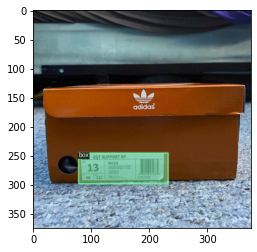

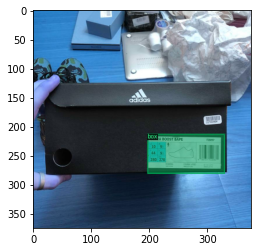

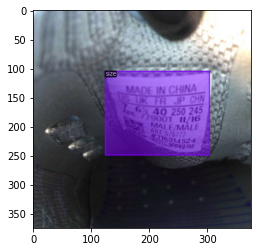

In [19]:

for d in random.sample(dataset_dicts, 3):
    window_name = 'image'
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=carplate_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

## Train Model

In [24]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(ROOT, CONFIG, "mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("carplate_train",)
cfg.DATASETS.TEST = ("carplate_val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = DEVICE
cfg.MODEL.WEIGHTS = os.path.join(ROOT,WEIGHTS,"R-50.pkl")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)


In [25]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 10:09:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

471
[06/06 10:09:19 d2.data.build]: Removed 1 images with no usable annotations. 470 images left.
[06/06 10:09:19 d2.data.common]: Serializing 470 elements to byte tensors and concatenating them all ...
[06/06 10:09:19 d2.data.common]: Serialized dataset takes 0.24 MiB
[06/06 10:09:19 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/06 10:09:19 d2.data.build]: Using training sampler TrainingSampler
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_b        of shape (64,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.weight          loaded from res2_0_branch2a_bn_s        of shape (64,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res

[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv2.norm.bias            loaded from res3_1_branch2b_bn_b        of shape (128,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv2.norm.weight          loaded from res3_1_branch2b_bn_s        of shape (128,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv2.weight               loaded from res3_1_branch2b_w           of shape (128, 128, 3, 3)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv3.norm.bias            loaded from res3_1_branch2c_bn_b        of shape (512,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv3.norm.weight          loaded from res3_1_branch2c_bn_s        of shape (512,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv3.weight               loaded from res3_1_branch2c_w           of shape (512, 128, 1, 1)
[06/06 10:09:19 d2.checkpoint.c2

[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.norm.weight          loaded from res4_2_branch2b_bn_s        of shape (256,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.weight               loaded from res4_2_branch2b_w           of shape (256, 256, 3, 3)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv3.norm.bias            loaded from res4_2_branch2c_bn_b        of shape (1024,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv3.norm.weight          loaded from res4_2_branch2c_bn_s        of shape (1024,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv3.weight               loaded from res4_2_branch2c_w           of shape (1024, 256, 1, 1)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.3.conv1.norm.bias            loaded from res4_3_branch2a_bn_b        of shape (256,)
[06/06 10:09:19 d2.checkpoint

[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv2.norm.bias            loaded from res5_1_branch2b_bn_b        of shape (512,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv2.norm.weight          loaded from res5_1_branch2b_bn_s        of shape (512,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv2.weight               loaded from res5_1_branch2b_w           of shape (512, 512, 3, 3)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv3.norm.bias            loaded from res5_1_branch2c_bn_b        of shape (2048,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv3.norm.weight          loaded from res5_1_branch2c_bn_s        of shape (2048,)
[06/06 10:09:19 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv3.weight               loaded from res5_1_branch2c_w           of shape (2048, 512, 1, 1)
[06/06 10:09:19 d2.checkpoint

  roi_heads.mask_head.predictor.{bias, weight}
[06/06 10:09:20 d2.checkpoint.c2_model_loading]: The checkpoint state_dict contains keys that are not used by the model:
  fc1000_b
  fc1000_w
  res2_0_branch2a_b
  res2_0_branch2b_b
  res2_0_branch2c_b
  res2_0_branch1_b
  res2_1_branch2a_b
  res2_1_branch2b_b
  res2_1_branch2c_b
  res2_2_branch2a_b
  res2_2_branch2b_b
  res2_2_branch2c_b
  res3_0_branch2a_b
  res3_0_branch2b_b
  res3_0_branch2c_b
  res3_0_branch1_b
  res3_1_branch2a_b
  res3_1_branch2b_b
  res3_1_branch2c_b
  res3_2_branch2a_b
  res3_2_branch2b_b
  res3_2_branch2c_b
  res3_3_branch2a_b
  res3_3_branch2b_b
  res3_3_branch2c_b
  res4_0_branch2a_b
  res4_0_branch2b_b
  res4_0_branch2c_b
  res4_0_branch1_b
  res4_1_branch2a_b
  res4_1_branch2b_b
  res4_1_branch2c_b
  res4_2_branch2a_b
  res4_2_branch2b_b
  res4_2_branch2c_b
  res4_3_branch2a_b
  res4_3_branch2b_b
  res4_3_branch2c_b
  res4_4_branch2a_b
  res4_4_branch2b_b
  res4_4_branch2c_b
  res4_5_branch2a_b
  res4_5_bran

/Users/dmitry/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/Users/dmitry/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


DIC {'file_name': '/Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/391.jpg', 'image_id': 131, 'height': 750, 'width': 750, 'annotations': [{'bbox': [158, 263, 395, 498], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[158.5, 498.5, 395.5, 498.5, 395.5, 263.5, 158.5, 263.5]], 'category_id': 1, 'iscrowd': 0}]}
DIC {'file_name': '/Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/363.jpg', 'image_id': 159, 'height': 750, 'width': 750, 'annotations': [{'bbox': [203, 156, 444, 399], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[203.5, 399.5, 444.5, 399.5, 444.5, 156.5, 203.5, 156.5]], 'category_id': 1, 'iscrowd': 0}]}
MAAAAPPPER /Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/363.jpg
MAAAAPPPER /Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/391.jpg
DIC {'file_name': '/Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/19

/Users/dmitry/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/Users/dmitry/anaconda3/envs/pytorch/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


DIC {'file_name': '/Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/342.jpg', 'image_id': 180, 'height': 750, 'width': 750, 'annotations': [{'bbox': [200, 71, 460, 295], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[200.5, 295.5, 460.5, 295.5, 460.5, 71.5, 200.5, 71.5]], 'category_id': 1, 'iscrowd': 0}]}
DIC {'file_name': '/Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/394.jpg', 'image_id': 128, 'height': 750, 'width': 750, 'annotations': [{'bbox': [338, 402, 620, 523], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[338.5, 523.5, 620.5, 523.5, 620.5, 402.5, 338.5, 402.5]], 'category_id': 0, 'iscrowd': 0}]}
MAAAAPPPER /Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/394.jpg
MAAAAPPPER /Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/342.jpg
DIC {'file_name': '/Users/dmitry/Documents/Business/Projects/Upwork/SportLabels/code/mask_rcnn/data/111.j

[06/06 10:16:57 d2.engine.hooks]: Total training time: 0:06:48 (0:00:00 on hooks)


KeyboardInterrupt: 

## Inference 

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "maskrcnn_model_final_20200522.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("carplate_val", )
predictor = DefaultPredictor(cfg)

186
Instances(num_instances=1, image_height=960, image_width=1280, fields=[pred_boxes: Boxes(tensor([[643.9741, 561.8832, 818.8071, 598.6920]])), scores: tensor([0.9999]), pred_classes: tensor([0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])


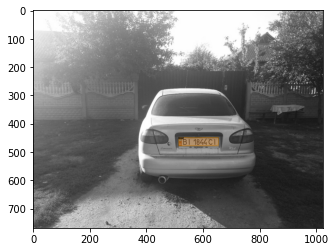

Instances(num_instances=1, image_height=1920, image_width=1080, fields=[pred_boxes: Boxes(tensor([[388.2898, 635.1368, 713.4877, 700.4047]])), scores: tensor([1.0000]), pred_classes: tensor([0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])


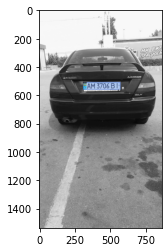

Instances(num_instances=1, image_height=932, image_width=1242, fields=[pred_boxes: Boxes(tensor([[ 812.8149,  571.3821, 1000.6432,  622.2923]])), scores: tensor([0.9999]), pred_classes: tensor([0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])


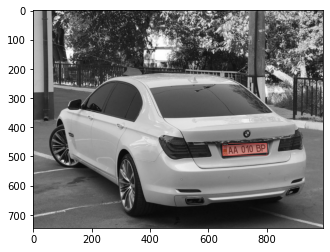

In [13]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_carplate_dicts('val')
for d in dataset_dicts[0:3]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=carplate_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to(DEVICE))
    print(outputs["instances"])
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("carplate", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "carplate")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/17 07:41:06 d2.data.common]: Serializing 1867 elements to byte tensors and concatenating them all ...
[05/17 07:41:06 d2.data.common]: Serialized dataset takes 0.99 MiB
[05/17 07:41:06 d2.evaluation.evaluator]: Start inference on 1867 images
[05/17 07:41:17 d2.evaluation.evaluator]: Inference done 1/1867. 9.9423 s / img. ETA=5:27:35
[05/17 07:41:25 d2.evaluation.evaluator]: Inference done 2/1867. 8.8538 s / img. ETA=4:48:34
[05/17 07:41:33 d2.evaluation.evaluator]: Inference done 3/1867. 8.4778 s / img. ETA=4:34:49
[05/17 07:41:41 d2.evaluation.evaluator]: Inference done 4/1867. 8.3616 s / img. ETA=4:30:06
[05/17 07:41:50 d2.evaluation.evaluator]: Inference done 5/1867. 8.3053 s / img. ETA=4:27:36
[05/17 07:41:58 d2.evaluation.evaluator]: Inference done 6/1867. 7.8618 s / img. ETA=4:11:03


KeyboardInterrupt: 